In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import starsim as ss # starsim is the Starsim framwork
from zombie import * # zombie is a custom zombie library, see zombie.py

# Numerical librarires and utilities
import numpy as np
import pandas as pd
import sciris as sc
import starsim as ss

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.dpi'] = 240

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Starsim 2.0.0 (2024-10-01) — © 2023-2024 by IDM


---
# Zombie Apocalypse: a case study in Starsim calibration and workflows
#### Adapted from Zombies: an introduction to Starsim by Dan Klein, 2024

A deep meta-analysis of recent and historical literature reveals that there are at least three zombiism transmission routes:
1. Be attacked by a zombie, and survive (to become another zombie)!
2. Acquire zombiism congenitally through vertical transmission during the prenatal period.
3. Die of natural causes and be transformed into a zombie upon death. 

Zombies have a few distinguishing features:
* There are two distinct types of zombies: slow and fast. The fast zombies are more aggressive and have more contacts than slow zombies.
* A zombie attack will always result in one of three outcomes: the victim becomes a zombie, the victim dies, or the victim survives.
* Zombies effectively don't die naturally, but they can slow down over time.
* There are no asymptomatic zombies. All zombies show symptoms immediately upon infection.

**Zombie** is an extension of the SIR disease that adds some important features:
  * **p_fast** is the probability of a zombie being fast.
  * **dur_fast** is the duration of a zombie being fast before reverting to slow, default 1000 years.
  * **dur_inf** is the duration of zombie infection, default is 1000 years. Once a zombie, always a zombie!
  * **p_symptomatic** is the probability of showing symptoms, default assumption is 100%.
  * **p_death_on_zombie_infection** is the probability of death when converting to a zombie.

**DeathZombies** is an extension of the base **Deaths** demographic class that captures people at natural death and potentially makes them zombies
  * **p_zombie_on_natural_death** is the probability of becoming a zombie on death due to natural causes

The **Pregnancy** and **MaternalNet** modules work together to simulate pregnancy, forming network connections between mothers and pre-birth children on which disease (zombie) transmission can occur.

We include an intervention, **KillZombies** that kills only *symptomatic* zombies.

Configuring and running the simulation takes less than one second.

---

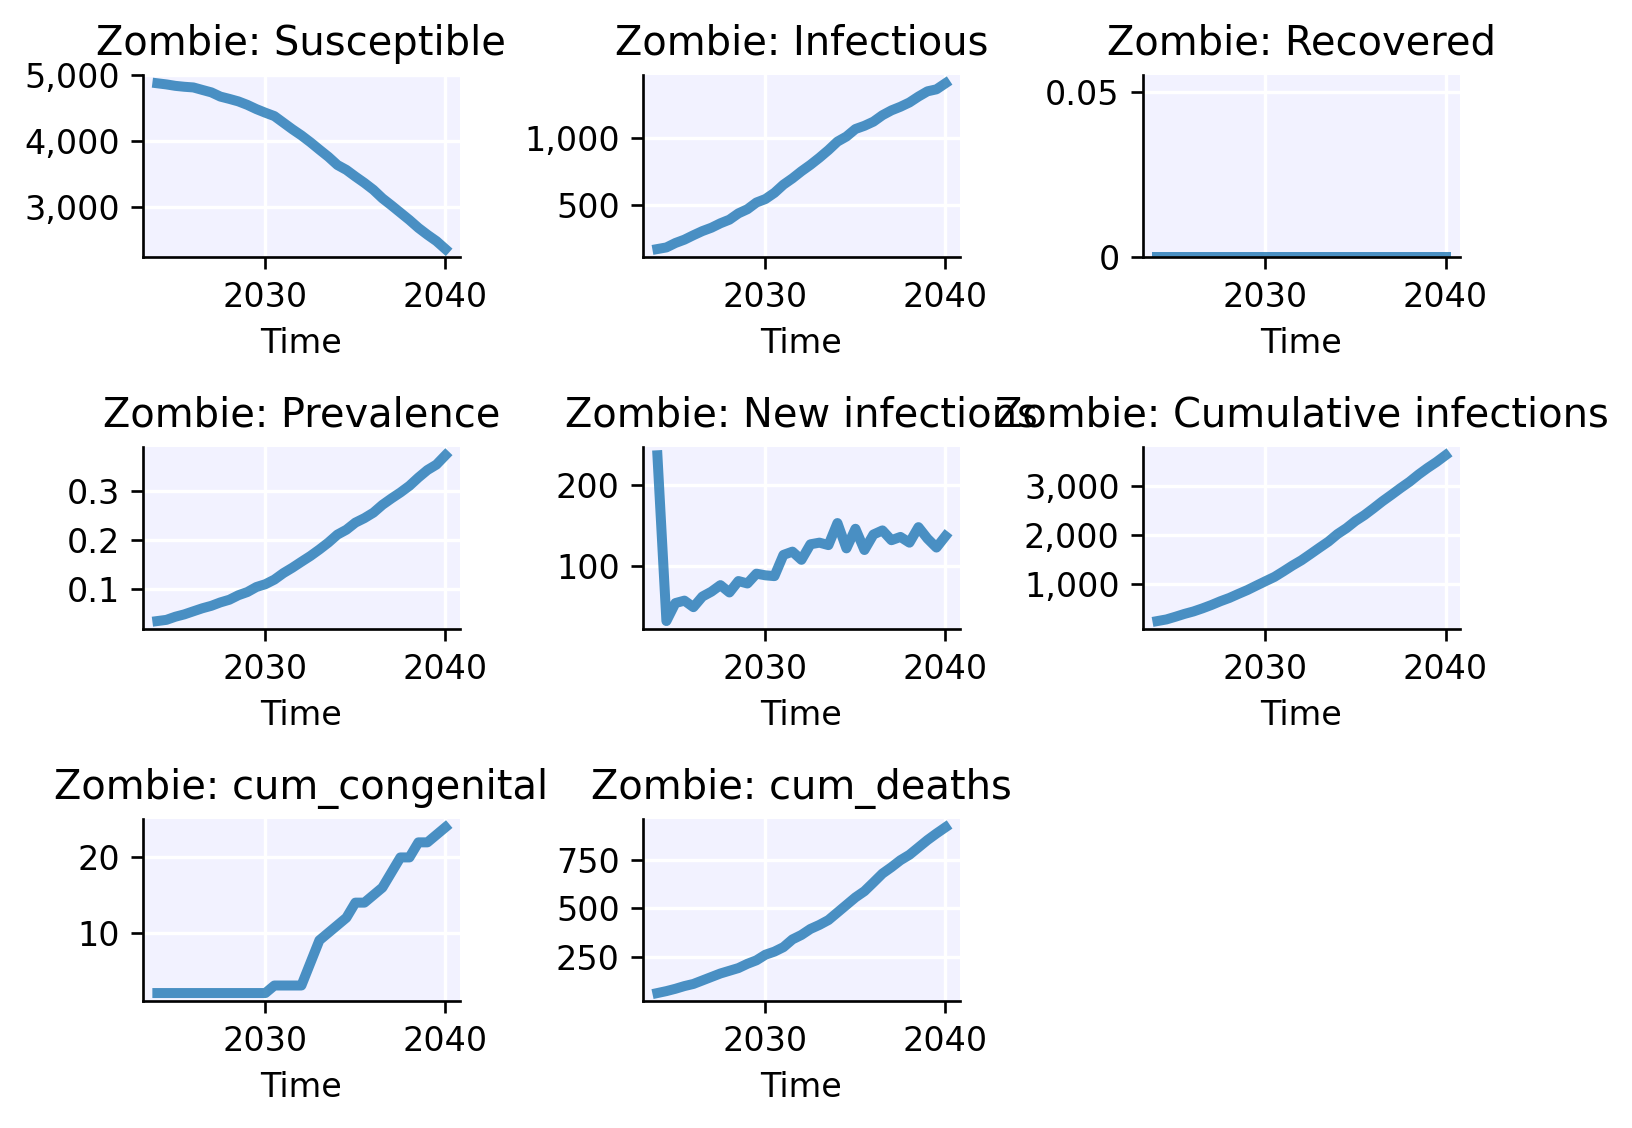

In [3]:
def basic_zombie():
    people = ss.People(n_agents=5_000)  # Population size

    # Configure and create an instance of the Zombie class
    zombie_pars = dict(
        init_prev=0.03,
        beta = ss.beta(0.05),
        p_fast=ss.bernoulli(p=0.1),
        p_death_on_zombie_infection=ss.bernoulli(p=0.25),
        p_symptomatic=ss.bernoulli(p=1.0),
    )
    zombie = Zombie(zombie_pars)

    # This function allows the lambda parameter to dynamically determine the number of contacts an agent has based on zombie type.
    # Fast zombies have more contacts than slow zombies.
    def choose_degree(self, sim, uids):
        mean_degree = np.full(fill_value=4, shape=len(uids))  # Default value is 4
        zombie = sim.diseases['zombie']
        is_fast = zombie.infected[uids] & zombie.fast[uids]
        mean_degree[is_fast] = 50  # Fast zombies get 50
        return mean_degree

    # We create two network layers, random and maternal
    networks = [
        ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
        ss.MaternalNet()
    ]

    # Configure and create demographic modules
    death_pars = dict(
        death_rate=15,  # per 1,000
        p_zombie_on_natural_death=ss.bernoulli(p=0.2),
    )
    deaths = DeathZombies(**death_pars)
    births = ss.Pregnancy(fertility_rate=175)  # per 1,000 women 15-49 annually
    demog = [births, deaths]

    # Create an intervention that kills symptomatic zombies
    interventions = KillZombies(year=2024, rate=0.1)

    # And finally bring everything together in a sim
    sim_pars = dict(start=2024, stop=2040, dt=0.5, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog,
                 interventions=interventions)

    # Run the sim and plot results
    sim.run()
    sim.results['zombie'].plot();

# Run the basic zombie simulation
basic_zombie()


---
# But what do we actually know about zombies?

![ChatCPT](img/chat.png "ChatGPT Fast Zombies")

Empirical data on Zombies is sparse. Here we analyze common hypotheses from the literature & scientific mechanisms:

| | Scenario Name | Default Value | Scenario Description |
| --- | --- | --- | --- |
| 0 | Default assumptions| N/A | Same as above |
| 1 | More fast zombies| 25% fast | 75% of zombies are fast |
| 2 | Fast-->slow zombies | 25% fast, forever | 75% of zombies start fast, but decay after about 2y |
| 3 | Finite infectious period | Infectious forever | Zombies remain infectious for about 5y |
| 4 | All zombies asymptomatic | All symptomatic | All asymptomatic |
| 5 | Less death on zombie infection | 25% die | 10% die on zombie infection |
| 6 | More zombies on natural death | 20% | 50% of natural deaths transform into a zombie |
| 7 | REALLY BAD | N/A | A worst case scenario |
---

In [4]:

scens = {
    'Default assumptions': {},
    'More fast zombies': {'zombie_pars': dict(p_fast=ss.bernoulli(p=0.75))},
    'Fast-->Slow zombies': {'zombie_pars': dict(p_fast=ss.bernoulli(p=0.75), dur_fast=ss.weibull(c=2, scale=2))},
    'Finite infectious period': {'zombie_pars': dict(dur_inf=ss.normal(loc=5, scale=2))},
    'All zombies asymptomatic': {'zombie_pars': dict(p_symptomatic=ss.bernoulli(p=0))},
    'Less death on zombie infection': {'zombie_pars': dict(p_death_on_zombie_infection=ss.bernoulli(p=0.10))},
    'More zombies on natural death': {'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=0.5))},
    'REALLY BAD': {'zombie_pars': dict(p_fast=ss.bernoulli(p=1.0), p_symptomatic=ss.bernoulli(p=0), p_death_on_zombie_infection=ss.bernoulli(p=0.50)),
                   'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=1.0))},
}

def run_zombies(scen, rand_seed, zombie_pars=None, death_pars=None, intvs=[], **kwargs):
    # When running using sciris parallelize in Jupyter on windows, previously imported modules are out of scope so reimport them
    import starsim as ss
    from zombie import Zombie, DeathZombies, KillZombies
    import sciris as sc
    import numpy as np
    import pandas as pd
    
    people = ss.People(n_agents=5_000) # People

    # Zombies
    zombie_defaults = dict(
        init_prev = 0.03,
        beta = ss.beta(0.05), #{'random': 0.05, 'maternal': 0.5},
        p_fast = ss.bernoulli(p=0.1),
        p_death_on_zombie_infection = ss.bernoulli(p=0.25),
        p_symptomatic = ss.bernoulli(p=1.0),
    )
    zombie_pars = sc.mergedicts(zombie_defaults, zombie_pars) # Override defaults with user-specified parameters
    zombie = Zombie(zombie_pars)

    def choose_degree(self, sim, uids):
        mean_degree = np.full(fill_value=4, shape=len(uids))  # Default value is 4
        zombie = sim.diseases['zombie']
        is_fast = zombie.infected[uids] & zombie.fast[uids]
        mean_degree[is_fast] = 50  # Fast zombies get 50
        return mean_degree


    # Networks
    networks = [
        ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
        ss.MaternalNet()
    ]

    # Deaths
    death_defaults = dict(
        death_rate = 15, # per 1,000 per year
        p_zombie_on_natural_death = ss.bernoulli(p=0.2),
    )
    death_pars = sc.mergedicts(death_defaults, death_pars)
    deaths = DeathZombies(**death_pars)

    # Births
    births = ss.Pregnancy(fertility_rate=175) # per 1,000 women 15-49 per year
    demog = [births, deaths]

    # Interventions
    interventions = KillZombies(year=2024, rate=0.1)
    interventions = [interventions] + sc.promotetolist(intvs) # Add interventions passed in

    # Create and run the simulation
    sim_pars = dict(start=2024, stop=2040, dt=0.5, rand_seed=rand_seed, label=scen, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog, interventions=interventions)
    sim.run()

    # Package results
    df = pd.DataFrame( {
        'Year': sim.timevec,
        'Population': sim.results.n_alive,
        'Humans': sim.results.n_alive - sim.results.zombie.n_infected,
        'Zombies': sim.results.zombie.n_infected,
        'Zombie Prevalence': sim.results.zombie.prevalence,
        'Congential Zombies (cum)': sim.results.zombie.cum_congenital,
        'Zombie-Cause Mortality': sim.results.zombie.cum_deaths,
    })
    df['rand_seed'] = rand_seed
    df['Scen'] = scen
    for key, val in kwargs.items():
        df[key] = val

    return df


    


Running 24 zombie simulations...
Completed in 37.3s


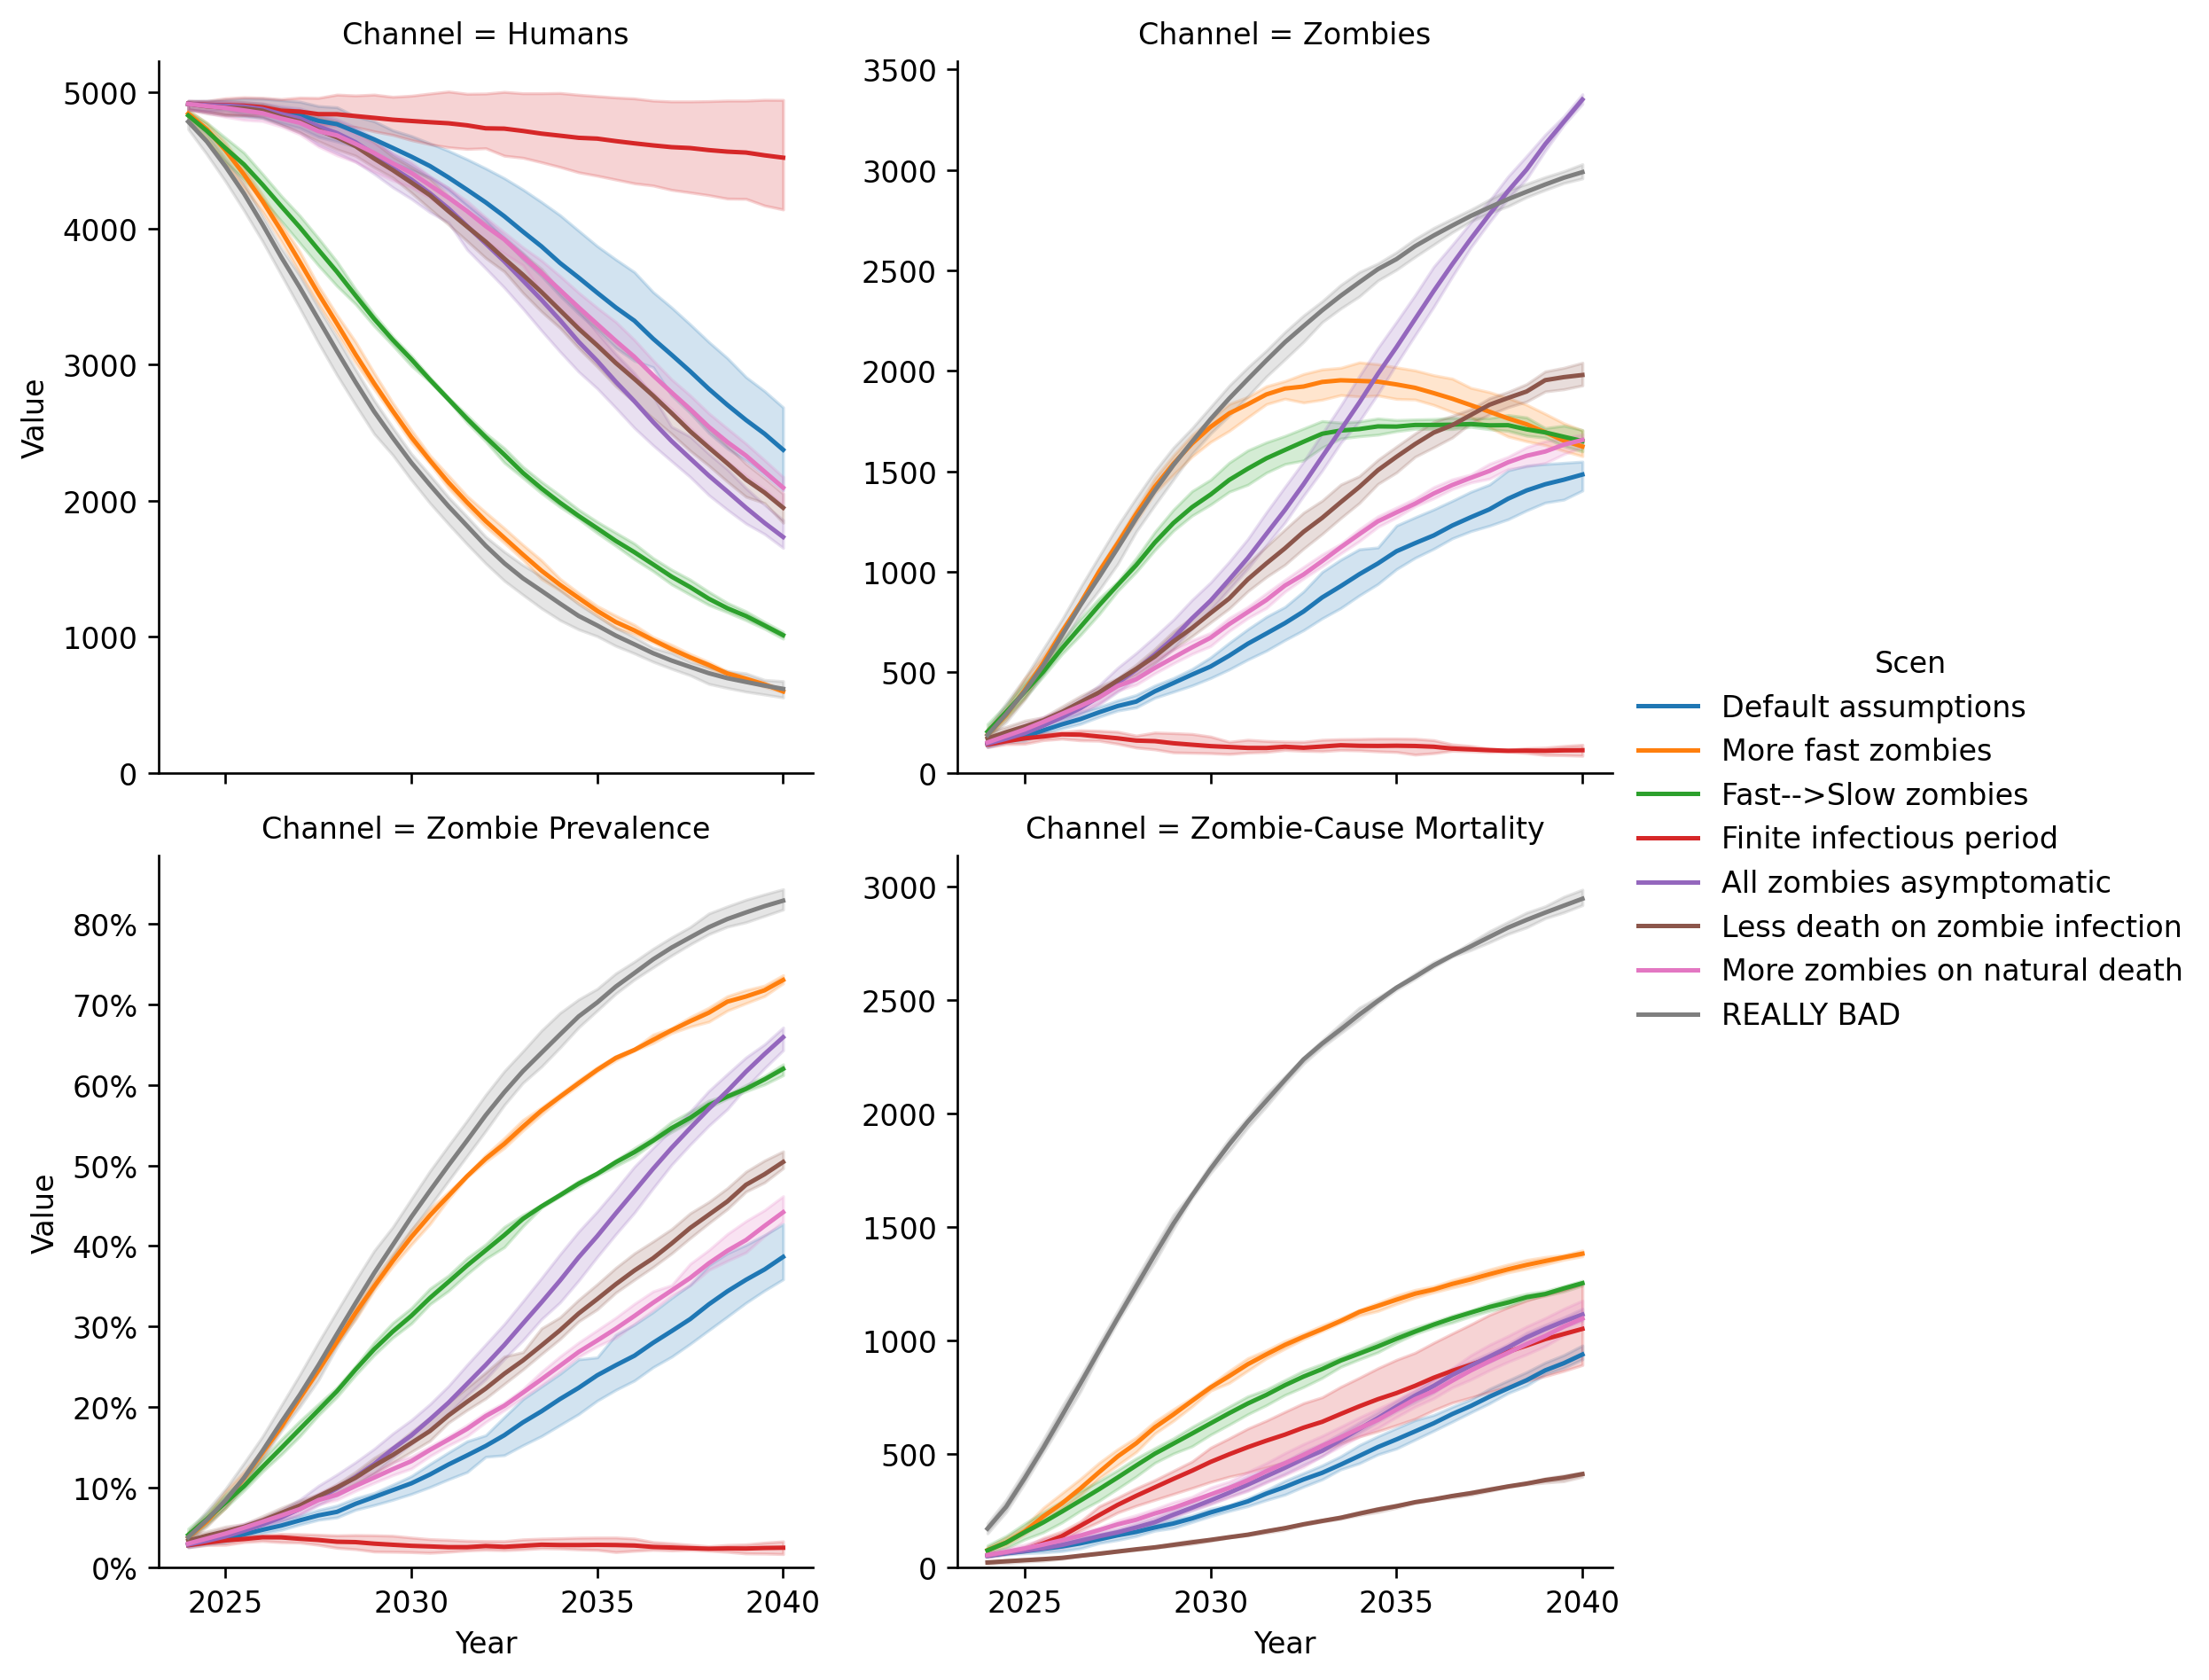

In [5]:
def run_scens():
    # Now run all the scenarios in parallel, repeating each configuration 3 times
    n_repeats = 3

    results = []
    cfgs = []

    for skey, scen in scens.items():
        for rand_seed in range(n_repeats):
            cfgs.append({'scen': skey, 'rand_seed': rand_seed} | scen)

    print(f'Running {len(cfgs)} zombie simulations...')
    T = sc.tic()
    results += sc.parallelize(run_zombies, iterkwargs=cfgs)
    print(f'Completed in {sc.toc(T, output=True):.1f}s')
    df = pd.concat(results).replace(np.inf, np.nan)

    # Display the first few reows of the results data frame
    # display(df.head())

    # Manipulate the data and create a plot using the Seaborn library
    dfm = df.melt(id_vars=['Scen', 'Year', 'rand_seed'],
                  value_vars=['Humans', 'Zombies', 'Zombie Prevalence', 'Zombie-Cause Mortality'], var_name='Channel',
                  value_name='Value')
    g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', hue_order=scens.keys(),
                    facet_kws=dict(sharey=False), col_wrap=2, height=4)
    g.set(ylim=(0, None))
    g.axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1));

run_scens()

# The scenario:

In 2024 there was an outbreak of a mysterious zombie disease at the local hospital of a small town. Initially there were only 5 cases reported, but it quickly spread throughout the town. The situation is grim: the town has been quarantined for the last 16 years in the hopes of identifying a cure, and the zombie illness has spread to nearly every resident of the town. During this time, we have observed a lot about how the virus behaves, and have created a model, Zombiesim, to simulate the outbreak. 


# To be able to model how interventions might control the outbreak, we must first understand the basic characteristics of the virus:
* beta: how likely contact with a zombie results in death and/or zombification
* p_fast: how many zombies are fast (and thus have more network contacts)

We have been provided with a dataset of the number of zombies present in the town each year. We will use this data to calibrate our model and determine the best values for beta and p_fast.

In [8]:
# Implement custom calibration class
class ZombieCalibration(ss.Calibration):

    
    @staticmethod
    def translate_pars(sim=None, calib_pars=None):
        import starsim as ss
        
        sim.pars['verbose'] = 0

        spec = calib_pars.pop('zombie_beta', None)
        if spec is not None:
            sim.diseases['zombie'].pars['beta']['random'].set(spec['value'])

        sim = ss.Calibration.translate_pars(sim, calib_pars)
        return sim
    
    def plot_calib_results(self, results_path=None, show=False):
        import matplotlib.pyplot as plt
        ''' Plot the observed and simulated hospitalization data for the best calibration'''

        # Summarize observed data
        df_actual = self.data.copy()

        df_pred = pd.DataFrame({'predicted.n_infected': self.after_sim.results.zombie.n_infected})
        df_pred['year'] = np.floor(self.after_sim.timevec).astype(int)
        df_init = pd.DataFrame({'year': self.before_sim.timevec, 'predicted.n_infected': self.before_sim.results.zombie.n_infected})
        df_init['year'] = np.floor(self.before_sim.timevec).astype(int)

        df_pred = df_pred.groupby(by='year').sum()
        df_init = df_init.groupby(by='year').sum()



        # Plot the observed & simulated timeseries
        plt.figure(figsize=(10, 6))
        plt.plot(df_actual.index, df_actual['zombie.n_infected'], marker='o', linestyle='-', label='Observed')
        plt.plot(df_pred.index, df_pred['predicted.n_infected'], marker='o', linestyle='-', label='Predicted', color='orange')
        plt.plot(df_init.index, df_init['predicted.n_infected'], marker='o', linestyle='-', label='Initial guess', color='green')
        plt.xlabel('Time')
        plt.ylabel('N infections by year')
        #plt.xticks(rotation=45)
        plt.tight_layout()
        plt.legend()  # This line adds the legend to the plot
        diff = np.round(np.sum(abs(df_actual['zombie.n_infected'] - df_pred['predicted.n_infected'])), 1)
        plt.text(0.99, 0.85, f'Obs - pred: {diff}', horizontalalignment='right', verticalalignment='center',
                 transform=plt.gca().transAxes)
        plt.savefig(f"{results_path}/zombie_timeseries.png")
        if show:
            plt.show()

In [9]:
def run_calibs():
    import numpy as np
    people = ss.People(n_agents=5_000)  # 5000 people live in the town

    # Configure and create an instance of the Zombie class
    zombie_pars = dict(
        init_prev = 0.001,  # 5 / 5_000, 5 people were initially infected
        beta = {'random': ss.beta(0.06), 'maternal': ss.beta(1)},   # Guess. To be calibrated
        p_fast=ss.bernoulli(p=0.1),  # Guess. To be calibrated
        p_death_on_zombie_infection=ss.bernoulli(p=0.15),
        p_symptomatic=ss.bernoulli(p=1.0),
    )
    zombie = Zombie(zombie_pars)

    def choose_degree(self, sim, uids):
        mean_degree = np.full(fill_value=4, shape=len(uids))  # Default value is 4
        zombie = sim.diseases['zombie']
        is_fast = zombie.infected[uids] & zombie.fast[uids]
        mean_degree[is_fast] = 50  # Fast zombies get 50
        return mean_degree

    # We create two network layers, random and maternal
    networks = [
        ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
        ss.MaternalNet()
    ]

    # Configure and create demographic modules
    death_pars = dict(
        death_rate=15,  # per 1,000 (during normal times!)
        p_zombie_on_natural_death=ss.bernoulli(p=0.15),  # Estimate based on observed data
    )
    deaths = DeathZombies(**death_pars)
    births = ss.Pregnancy(fertility_rate=175)  # per 1,000 women 15-49 annually (during normal times!)
    demog = [births, deaths]

    kill_int = KillZombies(year=2024, rate=0.1)  # no zombies are killed at the start

    intvs = [kill_int]

    # And finally bring everything together in a sim
    sim_pars = dict(start=2024, stop=2040, dt=0.5, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog, interventions=intvs)

    calib_pars = dict(
        zombie_beta = dict(guess=0.05, low=0.01, high=0.15, path=('diseases', 'zombie', 'beta')),
        zombie_p_fast = dict(guess=0.31, low=0.2, high=0.4, path=('diseases', 'zombie', 'p_fast')),
    )


    # Load the calibration data
    data = pd.read_csv('./zombie_outbreak_data_annual.csv')


    # Create the calibration object
    calib = ZombieCalibration(calib_pars=calib_pars,
                           sim=sim,
                           data=data,
                           total_trials=50,
                           name="demo2",
                           keep_db=False,
                           die=True,
                           verbose=True,
                              )

    calib.calibrate(confirm_fit=False, load=False, verbose=True)

    # Confirm
    #sc.printcyan('\nConfirming fit...')
    calib.confirm_fit()
    #print(f'Fit with original pars: {calib.before_fit:n}')
    #print(f'Fit with best-fit pars: {calib.after_fit:n}')

    calib.plot_calib_results(results_path='./', show=True)

In [10]:
# How does this compare with the observed data?


Removed existing calibration file demo2.db
sqlite:///demo2.db


[I 2024-10-03 15:12:08,964] A new study created in RDB with name: demo2


Making results structure...
Processed 60 trials; 0 failed
Best pars: {'zombie_beta': 0.09935748672462869, 'zombie_p_fast': 0.24753980340083742, 'rand_seed': 319911}
Could not delete study, skipping...
[WinError 32] The process cannot access the file because it is being used by another process: 'demo2.db'

Confirming fit...
Fit with original pars: 6.71109
Fit with best-fit pars: 2.06766
✓ Calibration improved fit


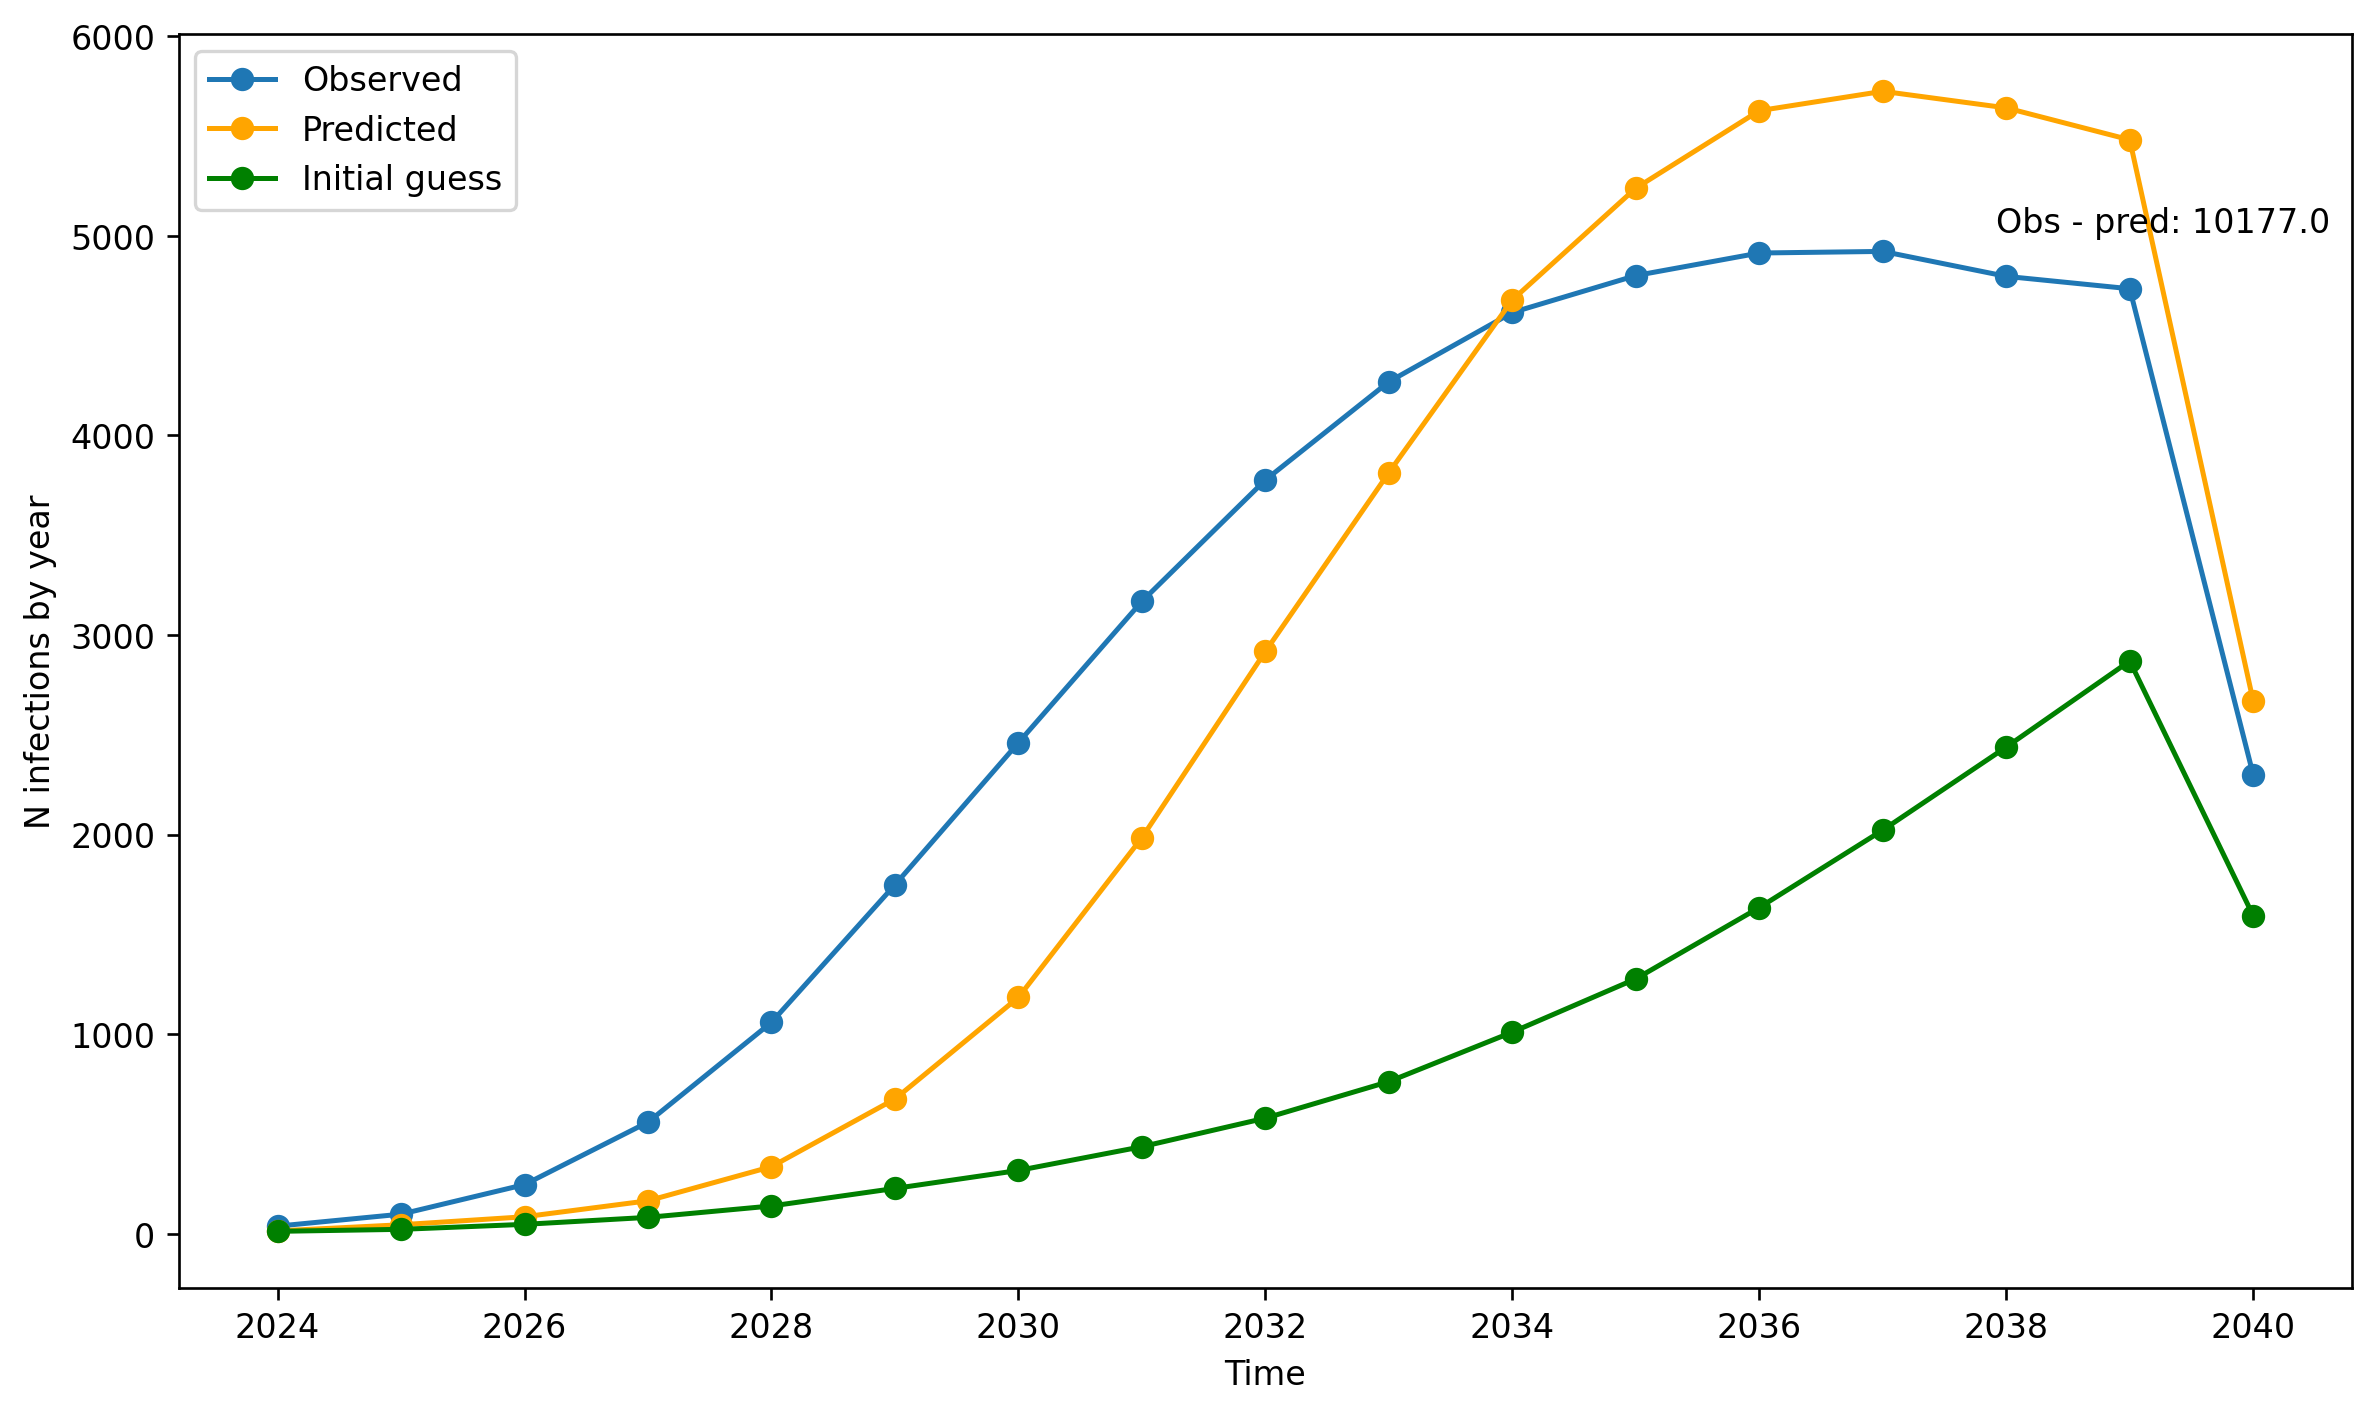

In [11]:
run_calibs()
